In [1]:
import sys
print(sys.executable) 

/home/aps/miniconda3/envs/options/bin/python


In [329]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import optax
import yfinance as yf
from ml.ml_utils import  binary_classification_metrics

In [48]:
#!pip install pandas_datareader

In [45]:
#!pip install nasdaq-data-link
#import nasdaqdatalink

In [46]:
#import nasdaqdatalink

In [ ]:
# to make envs available in notebooks
# pip install jax pandas matplotlib seaborn scikit-learn optax jaxopt
# conda install notebook ipykernel
# ipython kernel install --user --name=options

In [ ]:
# needed this on mac to get autocomplete to work
# %config Completer.use_jedi = False

## Use jax to implement major models

### What device is being used for computing?

Use conda to install cuda: conda install cuda -c nvidia

In [5]:
jax.devices()

[gpu(id=0)]

In [6]:
jax.devices()[0].platform

'gpu'

In [7]:
def jax_has_gpu():
    try:
        _ = jax.device_put(jax.numpy.ones(1), device=jax.devices('gpu')[0])
        return True
    except:
        return False
jax_has_gpu()

True

### Fit a linear regression

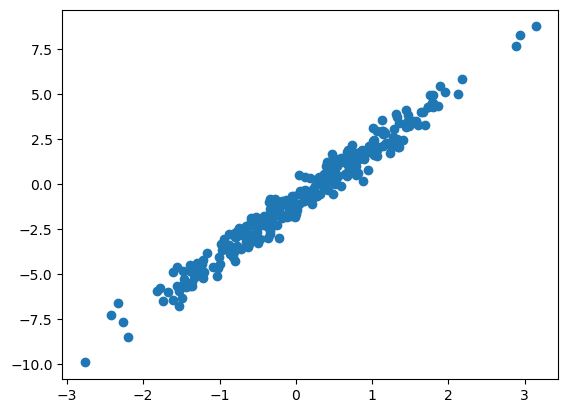

In [9]:
import numpy as np
import matplotlib.pyplot as plt

n = 300
xs = np.random.normal(size=(n,))
noise = np.random.normal(scale=0.5, size=(n,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);

In [10]:
# theta = [w, b] - model parameters
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

Loss function is the sum of squared errors, $ L = \frac{\Sigma (y - y_{pred})^2}{N}$

In [11]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [12]:
loss_fn((3,1), 0, 4)

Array(9., dtype=float32)

In [13]:
loss_fn((3,1), xs, ys)

Array(4.1818676, dtype=float32)

Use gradient discend to find the optimal parameters, 
$$
\theta_{updated}=\theta - \lambda\nabla_{\theta}L(\theta, x, y)
$$
where $\lambda$ is learning rate.

In [14]:
@jax.jit
def update(theta, x, y, lr=0.1):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [15]:
theta = jnp.array([1., 1.])
theta

Array([1., 1.], dtype=float32)

In [16]:
grad(loss_fn)(theta, 1., 1.)

Array([2., 2.], dtype=float32)

In [17]:
grad(loss_fn)(theta, 2., -1.)

Array([16.,  8.], dtype=float32)

Gradient returns the average gradient for vectors of variables.

In [18]:
grad(loss_fn)(theta, jnp.array([1., 2.]), jnp.array([1., -1.]))

Array([9., 5.], dtype=float32)

In [19]:
# initial parateters
theta = jnp.array([1., 1.])
theta
n_iterations = 200
lr = .1
for i in range(n_iterations):
    theta = update(theta, xs, ys, lr=lr)
theta

Array([ 2.9962494 , -0.97515374], dtype=float32)

### Compute greeks of Black-Scholes option prices with jax.grad

In [20]:
#@jax.jit
def bs_call(S, X, T, sig, r):
    d1 = (jnp.log(S/X) + (r + .5 * sig**2) * T)/(jnp.sqrt(T) * sig)
    print(f'd1 = {d1}')
    d2 = d1 - jnp.sqrt(T) * sig
    print(f'd2 = {d2}')
    c = S * jax.scipy.stats.norm.cdf(d1) - X * jnp.exp(-r*T)* jax.scipy.stats.norm.cdf(d2)
    print(f'delta = {jax.scipy.stats.norm.cdf(d1)}')
    return c

In [21]:
S=60.
X=65.
r=.08
sig=.30
T=.25
bs_call(S, X, T, sig, r)

d1 = -0.3252846896648407
d2 = -0.4752846956253052
delta = 0.3724828064441681


Array(2.1333694, dtype=float32)

In [22]:
# pars = [S, X, T, sig, r]
def euro_call(pars):
    S, X, T, sig, r = pars
    c = bs_call(S, X, T, sig, r)
    return c

In [23]:
euro_call([S, X, T, sig, r])

d1 = -0.3252846896648407
d2 = -0.4752846956253052
delta = 0.3724828064441681


Array(2.1333694, dtype=float32)

In [24]:
pars = [S, X, T, sig, r]
jax.grad(euro_call)(pars)

d1 = Traced<ConcreteArray(-0.3252846896648407, dtype=float32, weak_type=True)>with<JVPTrace(level=2/0)> with
  primal = Array(-0.3252847, dtype=float32, weak_type=True)
  tangent = Traced<ShapedArray(float32[], weak_type=True)>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[], weak_type=True), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f61d02bb460>, in_tracers=(Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>, Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(0.15000000596046448, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(-0.048792704939842224, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>, Traced<ConcreteArray(44.44444274902344, dtype=float32, weak_type=True):JaxprTrace(level=1/0)>), out_tracer_refs=[<weakref at 0x7f61d01c2de0; to 'JaxprTracer' at 0x7f61d01c2d40>], out_avals=[ShapedArray(float32[], weak_type=True)], primitive=pjit, params={'jaxpr': 

[Array(0.3724828, dtype=float32, weak_type=True),
 Array(-0.31100923, dtype=float32, weak_type=True),
 Array(8.428175, dtype=float32, weak_type=True),
 Array(11.351544, dtype=float32, weak_type=True),
 Array(5.0539, dtype=float32, weak_type=True)]

In [25]:
np.sqrt(4) + 2

4.0

### Random numbers

In [26]:
key = jax.random.PRNGKey(42)
print(random.normal(key, shape=(5,)))
print(random.normal(key, shape=(5,)))

[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]
[ 0.6122652  1.1225883 -0.8544134 -0.8127325 -0.890405 ]


In [27]:
# never reuse a key
key = jax.random.PRNGKey(42)
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))
key, subkey = random.split(key)
print(random.normal(subkey, shape=(5,)))

[-0.55338794  0.944283   -0.74176395 -0.5769758   1.1251862 ]
[-0.32761317 -0.4066346   1.2469071   1.1900425   1.100263  ]
[ 0.52089006  0.5769043  -0.843142   -0.88776976 -0.26607993]


## Common models

### Linear model

$y = wx + b$

Generate observed values

In [28]:
key = jax.random.PRNGKey(212)
w = jnp.array([1., -1., 3., 5., -2.])
b = 2
theta_true = jnp.append(w, b)
print(theta_true)

[ 1. -1.  3.  5. -2.  2.]


In [29]:
@jax.jit
def model(theta, x):
    w = theta[:-1]
    b = theta[-1]
    y = jnp.dot(w, x) + b
    return y

model_vmap = jax.vmap(model, in_axes=[None, 1])

In [30]:
model(theta_true, jnp.array([1, 2, 3, 4, 5]))

Array(20., dtype=float32)

In [31]:
np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]).reshape(5, 2)

array([[1, 2],
       [3, 4],
       [5, 1],
       [2, 3],
       [4, 5]])

In [32]:
#model_vmap(theta, np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5]).reshape(5, 2))

In [33]:
n_obs = 50
x_observed = jax.random.normal(key, shape=(5,n_obs))
print(x_observed.shape)
print(jnp.sum(x_observed, axis=1))


(5, 50)
[-1.9834338  3.6937184 -2.6479697  1.7907314 12.152573 ]


In [34]:
# observations - model plus some noise
y_observed = model(theta_true, x_observed) + jax.random.normal(key, shape=(n_obs,))
print(y_observed)

[  5.0615315    2.4697185   -3.1689072   -7.6509895   -3.878571
  11.230026     1.4037006    4.231458     9.178272     5.9207597
  -1.3583989   -4.3980184    5.34012      0.41575944  -1.9732018
  -8.83993      6.2698207   -2.5513077    6.314845    -8.689926
  -1.7106981   -5.669702     8.188997    10.294529     5.785759
  -5.8465557   17.606491     5.4771914   11.000769     7.3086863
  -3.7401242    6.7878776    8.182899     1.5911285    1.0267415
   4.3348236   -5.980621   -11.129906    -4.772352    -3.095614
  -0.26369235  -5.845175    -2.924248     3.485813    11.435972
  11.133466    -4.316735     0.92751515  -5.489374    -8.450031  ]


Text(0.5, 1.0, 'Noisy observations vs underlying model')

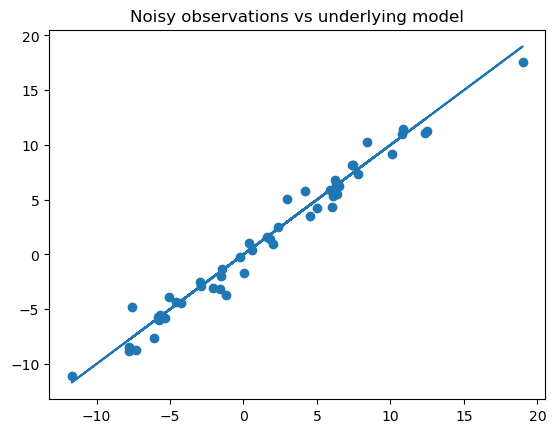

In [35]:
plt.scatter(model(theta_true, x_observed), y_observed)
plt.plot(model(theta_true, x_observed), model(theta_true, x_observed))
plt.title('Noisy observations vs underlying model')

In [36]:
%timeit model(theta_true, x_observed)

52.5 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [37]:
y_observed = model_vmap(theta_true, x_observed)
print(y_observed)

[ 2.9883356e+00  2.3349292e+00 -1.5650353e+00 -6.1130486e+00
 -5.0836453e+00  1.2472522e+01  1.8045750e+00  5.0270214e+00
  1.0129258e+01  5.9141598e+00 -1.4724889e+00 -4.2724571e+00
  6.0810957e+00  5.5440164e-01 -1.5313125e+00 -7.7776632e+00
  6.5286217e+00 -2.9492378e+00  6.2737894e+00 -7.3210154e+00
  1.4330387e-02 -5.8055058e+00  7.4530363e+00  8.3956413e+00
  4.1605120e+00 -5.3344989e+00  1.8990658e+01  6.3681192e+00
  1.0795193e+01  7.7783060e+00 -1.1883299e+00  6.2501440e+00
  7.3560801e+00  1.6167397e+00  3.5765314e-01  6.0111747e+00
 -5.7826834e+00 -1.1694789e+01 -7.5610752e+00 -2.0660710e+00
 -2.2288561e-01 -5.6120420e+00 -2.8691716e+00  4.5343018e+00
  1.0853861e+01  1.2338906e+01 -4.6002135e+00  1.9807799e+00
 -5.6962886e+00 -7.8172445e+00]


In [38]:
# slower tham model?
%timeit model_vmap(theta_true, x_observed)

659 µs ± 6.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
# loss function - mean squared error
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [40]:
# update step
@jax.jit
def update(theta, x, y, lr=0.01):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [41]:
# initial parateters
theta = jnp.array([1., 1., 1., 1., 1., 1.])
theta
n_iterations = 1000
lr = .01
for i in range(n_iterations):
    theta = update(theta, x_observed, y_observed, lr=lr)
print('True vs fitted parameters:')
print(jnp.vstack([jnp.round(theta, 4), theta_true]))


True vs fitted parameters:
[[ 1. -1.  3.  5. -2.  2.]
 [ 1. -1.  3.  5. -2.  2.]]


### Logistic regression classifier

First, we create data using bivariate normal distribution.

In [42]:
class1 = random.multivariate_normal(key,
                           mean=jnp.array([1, 1]),
                           cov=.5*np.array([1, .5, .5, 1]).reshape(2,2),
                          shape=[100,])
class1[:5,:]

Array([[ 2.2076726 ,  0.63324547],
       [ 0.53972983, -0.5107355 ],
       [ 1.6998711 ,  1.4444137 ],
       [-0.05809402,  1.3304108 ],
       [ 0.23326337,  0.6060622 ]], dtype=float32)

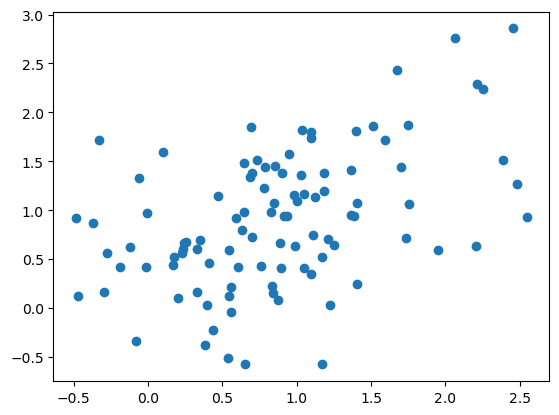

In [43]:
plt.scatter(class1[:, 0], class1[:, 1])

In [44]:
key, subkey = random.split(key)
class2 = random.multivariate_normal(key,
                           mean=jnp.array([3, 3]),
                           cov=.5*np.array([1, .7, .7, 1]).reshape(2,2),
                          shape=[100,])
class2[:5,:]

Array([[3.6587057, 3.276566 ],
       [2.3907404, 3.2305648],
       [2.9801316, 2.669557 ],
       [1.739017 , 1.6249541],
       [2.5033264, 2.8402581]], dtype=float32)

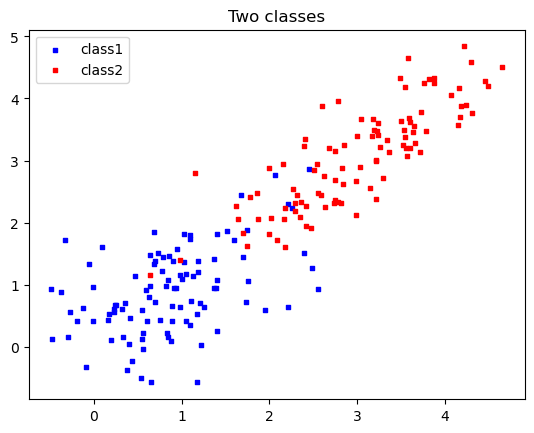

In [45]:

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(class1[:, 0], class1[:, 1], s=10, c='b', marker="s", label='class1')
ax1.scatter(class2[:, 0], class2[:, 1], s=10, c='r', marker="s", label='class2')
plt.title('Two classes')
plt.legend()


Logistic regression models the probability of belonging to $class1$ as
$$
p = \frac{1}{1+e^{-(wx + b)}},
$$
where, in our case, $w = (w_1, w_2), x = (x_1, x_2)$, and $b$ is a scalar.
The loss function at $p_k, y_k$ is defined as 

$$
\left\{
\begin{array}{l}
      -log(p_k),\ if\  y_k = 1\ \    (class 1),\\
      -log(1-p_k),\ if\  y_k=0 \ \    (class 2).
      \end{array}
  \right.
$$
Combining, we get cross entropy loss function

$$
L = -\Sigma_1^N (y_k\log(p_k) + (1-y_k)log(1-p_k)).
$$

In [46]:
# implement functions
@jax.jit
def sigmoid(t):
    return 1/(1 + jnp.exp(-t))

@jax.jit
def model(theta, x):
    w = theta[:-1]
    b = theta[-1]
    t = jnp.dot(w, x) + b
    p = sigmoid(t)
    return p

# loss function - cross entropy
def loss_fn(theta, x, y):
  p = model(theta, x)
#  print(theta.dtype)
#  print(y.dtype)
# print(y*(jnp.log(p) + (1-y)*jnp.log(1-p)))    
  return -jnp.mean(y*jnp.log(p) + (1-y)*jnp.log(1-p))

# update step
@jax.jit
def update(theta, x, y, lr=0.01):
  return theta - lr * grad(loss_fn)(theta, x, y)

In [47]:
class1[:5, :]

Array([[ 2.2076726 ,  0.63324547],
       [ 0.53972983, -0.5107355 ],
       [ 1.6998711 ,  1.4444137 ],
       [-0.05809402,  1.3304108 ],
       [ 0.23326337,  0.6060622 ]], dtype=float32)

In [48]:
theta = np.array([1., 1., 1.])
model(theta, class1[:5, :].transpose())

Array([0.97897756, 0.73672086, 0.98439276, 0.9065582 , 0.8628689 ],      dtype=float32)

In [49]:
loss_fn(theta, data[:,:-1].transpose(), lbl)

NameError: name 'data' is not defined

In [50]:
# alternative cross entropy function
from sklearn.metrics import log_loss
lbl = jnp.concatenate((jnp.ones(shape=(len(class1),)), jnp.zeros(shape=(len(class2),))))
data = jnp.column_stack((jnp.row_stack((class1, class2)), lbl))
log_loss(lbl, model(theta, data[:,:-1].transpose()))

3.565970814956701

In [51]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [52]:
BinaryCrossEntropy(lbl, model(theta, data[:,:-1].transpose()))

Array(3.5658102, dtype=float32)

In [53]:
update(theta, class1[:, :].transpose(), jnp.ones(shape=(len(class1),)))

Array([1.0003867, 1.0003953, 1.0009131], dtype=float32)

In [95]:
#input data
lbl = jnp.concatenate((jnp.ones(shape=(len(class1),)), jnp.zeros(shape=(len(class2),))))
data = jnp.column_stack((jnp.row_stack((class1, class2)), lbl))
print(data.shape)
print(data[:5, :])
print(data[-5:, :])
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    data[:,:-1], 
    data[:,-1], 
    test_size=0.3, random_state=212
)

(200, 3)
[[ 2.2076726   0.63324547  1.        ]
 [ 0.53972983 -0.5107355   1.        ]
 [ 1.6998711   1.4444137   1.        ]
 [-0.05809402  1.3304108   1.        ]
 [ 0.23326337  0.6060622   1.        ]]
[[4.2168283 4.838749  0.       ]
 [3.027188  2.895407  0.       ]
 [4.1475687 3.578512  0.       ]
 [3.8165798 4.3165026 0.       ]
 [0.9768336 1.3954045 0.       ]]


In [96]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_test.sum())

(140, 2)
(60, 2)
(140,)
(60,)
30.0


In [97]:
# fit parameters
# initial parateters
theta = jnp.array([1., 1., 1.])
n_iterations = 500
lr = .1
for i in range(n_iterations):
    #print(theta)
    theta = update(theta, X_train.transpose(), y_train, lr=lr)
    print(loss_fn(theta, X_train.transpose(), y_train), loss_fn(theta, X_test.transpose(), y_test))
#print(theta)


3.1687317 2.9157207
2.6889741 2.48175
2.2205 2.059703
1.7718313 1.6576842
1.3596144 1.2906746
1.012599 0.98337924
0.7634139 0.7628756
0.6172642 0.6326694
0.5421018 0.56481814
0.50348717 0.5293926
0.4822276 0.50956506
0.46948668 0.49749896
0.46118453 0.48953354
0.45532972 0.4838617
0.4508901 0.4795364
0.44730198 0.47603482
0.44424433 0.4730556
0.44152758 0.4704189
0.43903673 0.46801388
0.43670037 0.46577084
0.4344732 0.46364474
0.43232614 0.46160612
0.43024018 0.45963505
0.42820278 0.45771822
0.4262054 0.4558463
0.42424244 0.4540127
0.42230982 0.45221266
0.42040488 0.45044288
0.41852564 0.44870064
0.41667068 0.44698408
0.41483882 0.44529164
0.41302928 0.44362205
0.41124144 0.4419744
0.4094747 0.44034776
0.40772858 0.4387415
0.4060027 0.437155
0.40429667 0.43558767
0.40261012 0.43403912
0.40094277 0.4325088
0.39929432 0.43099642
0.39766443 0.4295015
0.39605284 0.42802376
0.39445928 0.42656285
0.39288348 0.4251185
0.39132515 0.42369038
0.38978404 0.42227817
0.38825995 0.42088175
0.3867526

0.20605557 0.2571549
0.20594057 0.25706252
0.20582595 0.2569705
0.20571178 0.25687882
0.20559798 0.2567875
0.20548458 0.2566966
0.20537157 0.256606
0.20525895 0.2565158
0.20514673 0.256426
0.20503488 0.25633654
0.20492342 0.2562474
0.20481235 0.25615865
0.20470166 0.25607026
0.20459136 0.25598222
0.20448142 0.2558945
0.20437187 0.25580716
0.20426267 0.25572014
0.20415385 0.2556335
0.2040454 0.2555472
0.20393732 0.25546122
0.2038296 0.25537562
0.20372227 0.25529033
0.20361528 0.25520536
0.20350865 0.25512075
0.20340239 0.25503647
0.20329647 0.25495252
0.20319092 0.2548689
0.2030857 0.25478563
0.20298086 0.25470266


In [57]:
#jnp.column_stack((model(theta, X_train.transpose()), y_train))

In [98]:
from ml.ml_utils import  binary_classification_metrics
binary_classification_metrics(y_train,
                              jnp.round(model(theta, X_train.transpose()), 0),
                              model(theta, X_train.transpose()),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5,0.9,0.9714,0.9357,0.9692,0.9333,0.0286,0.8737,0.9855,0.203


In [99]:
# now for test data
binary_classification_metrics(y_test,
                              jnp.round(model(theta, X_test.transpose()), 0),
                              model(theta, X_test.transpose()),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5,0.9667,0.9333,0.95,0.9355,0.9508,0.0667,0.9005,0.9656,0.2547


Draw a decision boundary using cutoff of 0.5
$$
w_1x_1 + w_2x_2 + b = 0, \newline
x_2 = -\frac{w_1}{w_2}x_1 - \frac{b}{w_2}
$$ 

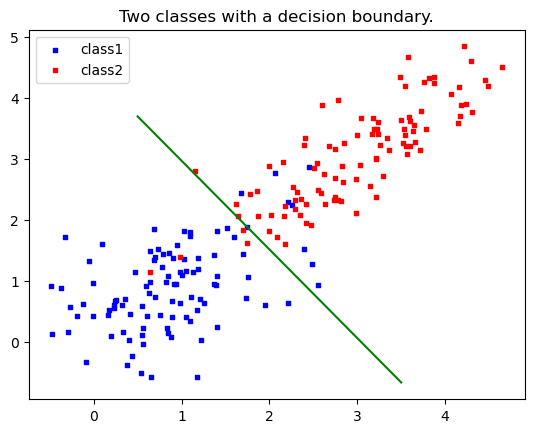

In [100]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(class1[:, 0], class1[:, 1], s=10, c='b', marker="s", label='class1')
ax1.scatter(class2[:, 0], class2[:, 1], s=10, c='r', marker="s", label='class2')
x1 = jnp.linspace(.5, 3.5, 50)
x2 = ( -theta[0]*x1 - theta[2])/theta[1]
ax1.plot(x1, x2, c='g')
plt.title('Two classes with a decision boundary.')
plt.legend()


In [101]:
theta[2]

Array(3.6837006, dtype=float32)

### Fully connected neural network.

$x \in R^n$, an input vector, transformed to a vector of length $m$ via 
$$
x = xW + b, \newline
x = activation\_function(x),
$$
where $W \in R^{n\times m}, b \in R^m$.
This represents one layer of the network. The final layer transforms to the dimension of the output, and in case of classsification - sigmoid.


In [3]:
# A link to the data is availailable in the following blog post
# https://scipython.com/blog/a-shallow-neural-network-for-simple-nonlinear-classification/
df = pd.read_csv('../non_linear_class_example/labeled_points.txt', sep=' ',
                usecols=[1,3,5], names=['x1', 'x2', 'label'])

In [4]:
df.head()

,x1,x2,label
0,0.50873,0.08490,1
1,0.96767,0.96752,1
2,0.72096,0.90628,1
3,0.66071,0.32757,1
4,0.48690,0.58265,0


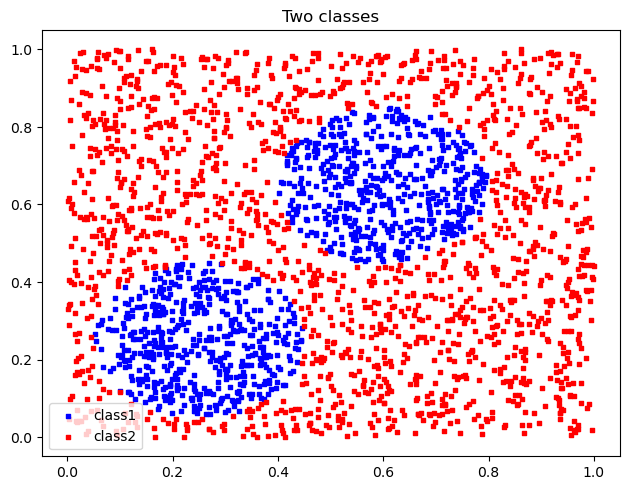

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
df_cl1 = df[df.label == 0]
df_cl2 = df[df.label == 1]
ax1.scatter(df_cl1.x1, df_cl1.x2, s=5, c='b', marker="s", label='class1')
ax1.scatter(df_cl2.x1, df_cl2.x2, s=5, c='r', marker="s", label='class2')
fig.tight_layout()
plt.title('Two classes')
plt.legend()


In [6]:
# 
x = jnp.array(df[['x1', 'x2']])
y = jnp.array(df['label'])
print(x.shape)
print(y.shape)

(2506, 2)
(2506,)


In [8]:
#first point
print(x[0])
# W dim
input_dim = 2
hidden_dim = 100
key = jax.random.PRNGKey(42)
#key, subkey = random.split(key)
#print(random.normal(subkey, shape=(5,)))
print('init inputs with random numbers:')
W = jax.random.normal(key, shape=(input_dim, hidden_dim)) * .01
b = jax.random.normal(key, shape=(1, hidden_dim)) * .01
W1 = jax.random.normal(key, shape=(hidden_dim, hidden_dim)) * .01
b1 = jax.random.normal(key, shape=(1, hidden_dim)) * .01
w = jax.random.normal(key, shape=(hidden_dim, 1)) * .01
print('dimensions:')
print('W:', W.shape)
print('b:', b.shape)
print('W1:', W1.shape)
print('b1:', b1.shape)
print('w:', w.shape)
#print('model:')
#print(model((W, b, W1, b1, w), x[0:10]))
#print('loss function:')
#print(loss_fn((W, b, W1, b1, w), x[0:10], y[0:10]))
#print('gradient dim:')
#print(list(map(lambda i: i.shape, grad(loss_fn)((W, b, W1, b1, w), x[0:5], y[0:5]))))

[0.50873 0.0849 ]
init inputs with random numbers:
dimensions:
W: (2, 100)
b: (1, 100)
W1: (100, 100)
b1: (1, 100)
w: (100, 1)


In [9]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    x, 
    y,
    stratify=y,
    test_size=0.3, random_state=212
)
print(list(map(lambda i: i.shape, (X_train, X_test, y_train, y_test))))
print(y_train.sum(), y_test.sum())

[(1754, 2), (752, 2), (1754,), (752,)]
1051 451


#### 2-layer nn using optax for optimization

In [36]:
key, w1key, b1key, w2key, b2key, w3key, b3key = jax.random.split(key, 7)
num_input = X_train.shape[1]
num_hidden1 = 128
num_hidden2 = 128
num_labels = y_train.max() + 1
print('Dimensions are ', num_input, num_hidden1, num_labels)
#num_hidden2 = 1024
params = dict(
    w1 = 1e-2*jax.random.normal(w1key, (num_input, num_hidden1)),
    b1 = 1e-2*jax.random.normal(b1key, (1, num_hidden1)),
    w2 = 1e-2*jax.random.normal(w2key, (num_hidden1, num_hidden2)),
    b2 = 1e-2*jax.random.normal(b2key, (1, num_hidden2)),
    w3 = 1e-2*jax.random.normal(w3key, (num_hidden2, num_labels)),
    b3 = 1e-2*jax.random.normal(b3key, (1, num_labels)),
)
for k in params.keys():
    print(f'Dimensions of {k} are ', params[k].shape)

Dimensions are  2 128 2
Dimensions of w1 are  (2, 128)
Dimensions of b1 are  (1, 128)
Dimensions of w2 are  (128, 128)
Dimensions of b2 are  (1, 128)
Dimensions of w3 are  (128, 2)
Dimensions of b3 are  (1, 2)


In [37]:
@jax.jit
def net(params, x):
    x = jax.nn.relu(x@params["w1"] + params["b1"])
    x = jax.nn.relu(x@params["w2"] + params["b2"])
    x = x@params["w3"] + params["b3"]
#     x = sigmoid(x)
    return x

### Common loss functions

#### L2 loss or squared loss

$$
Loss(y, \hat{y}) = 0.5 * (y -\hat{y})^2
$$

In [15]:
import optax._src.loss as optax_loss
l2 = optax_loss.l2_loss(jnp.array([1., 2., 3.]), jnp.array([1., 2.,3.]) + jax.random.normal(key, shape=(3,)))
print(l2)
# the acctual loss function should return the mean
print(l2.mean())

[1.1757147e-03 1.4729156e+00 1.3867368e-01]
0.53758836


#### Softmax cross entropy

In [16]:
net(params, x[0:10])

Array([[ 0.01146681, -0.00883568],
       [ 0.01149749, -0.0088382 ],
       [ 0.01148136, -0.00883772],
       [ 0.01147696, -0.00883594],
       [ 0.01146699, -0.00883682],
       [ 0.01144741, -0.00884022],
       [ 0.0114938 , -0.0088306 ],
       [ 0.01146762, -0.00883694],
       [ 0.01148721, -0.00883548],
       [ 0.01145677, -0.00883814]], dtype=float32)

In [143]:
y[:10]

Array([1, 1, 1, 1, 0, 0, 1, 1, 1, 0], dtype=int32)

In [144]:
jax.nn.one_hot(y[0:10], 2)

Array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [17]:
xe = optax_loss.softmax_cross_entropy(net(params, x[0:10]), jax.nn.one_hot(y[0:10], 2))
print(xe)
print(xe.mean())

[0.70334995 0.70336664 0.70335835 0.7033552  0.6830468  0.6830548
 0.70336103 0.70335096 0.7033601  0.6830512 ]
0.69726557


In [18]:
# implement
@jax.jit
def xeloss(x, y):
#    _elementwise_xeloss = jax.vmap(lambda x, y: -jax.nn.log_softmax(x)[y])
    _elementwise_xeloss = jax.vmap(lambda x, y: -jax.nn.log_softmax(x)[y])
    #print(_elementwise_xeloss(x, y))
    return _elementwise_xeloss(x, y).mean()

In [19]:
print('model:')
print(net(params, x[0:10]))
print('loss functions:')
print(xeloss(net(params, x[0:10]), y[0:10]))


model:
[[ 0.01146681 -0.00883568]
 [ 0.01149749 -0.0088382 ]
 [ 0.01148136 -0.00883772]
 [ 0.01147696 -0.00883594]
 [ 0.01146699 -0.00883682]
 [ 0.01144741 -0.00884022]
 [ 0.0114938  -0.0088306 ]
 [ 0.01146762 -0.00883694]
 [ 0.01148721 -0.00883548]
 [ 0.01145677 -0.00883814]]
loss functions:
0.69726557


#### Softmax cross entropy for binary classification

In [20]:
@jax.jit
def sigmoidXEloss(params: optax.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
  y_hat = net(params, batch)
  # optax also provides a number of common loss functions.
  loss_value = optax.sigmoid_binary_cross_entropy(y_hat, labels).sum(axis=-1)

  return loss_value.mean()

sigmoidXEloss(params, x[:10], jax.nn.one_hot(y[:10], 2))

Array(1.3903873, dtype=float32)

In [21]:
@jax.jit
def softmaxXEloss(params: optax.Params, batch: jnp.ndarray, labels: jnp.ndarray) -> jnp.ndarray:
  y_hat = net(params, batch)
  # optax also provides a number of common loss functions.
  loss_value = optax_loss.softmax_cross_entropy(y_hat, labels)
  return loss_value.mean()

softmaxXEloss(params, x[:10], jax.nn.one_hot(y[:10], 2))

Array(0.69726557, dtype=float32)

In [22]:
@jax.jit
def accuracy(x, y):
    return 100*(jnp.argmax(x, 1) == y).mean()
accuracy(net(params, x[0:10]), y[0:10])

Array(30., dtype=float32)

In [23]:
@jax.jit
def lossforward(params, x, y):
    x = net(params, x)
    loss = xeloss(x, y)
    return loss
lossforward(params, x[0:10], y[0:10])

Array(0.69726557, dtype=float32)

In [24]:
print(y[0:10])
jax.nn.one_hot(y[0:10], 2)

[1 1 1 1 0 0 1 1 1 0]


Array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [25]:
#import optax
optax.sigmoid_binary_cross_entropy(net(params, x[0:10]), jax.nn.one_hot(y[0:10], 2)).sum(axis=-1).mean()

Array(1.3903874, dtype=float32)

In [154]:
#print(-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2))
#print(-jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
#print(-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2) -
#    jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
#xe = (-jnp.log(sigmoid(net(params, x[0:10]))) * jax.nn.one_hot(y[0:10], 2) -
#    jnp.log(sigmoid(-net(params, x[0:10]))) * (1-jax.nn.one_hot(y[0:10], 2)))
#print(xe.sum(axis=-1))
#xe.sum(axis=-1).mean()

In [155]:
jnp.log(sigmoid(-0.00092671))

Array(-0.6936107, dtype=float32, weak_type=True)

In [156]:
jnp.log(jax.nn.sigmoid(-0.00092671))

Array(-0.6936107, dtype=float32, weak_type=True)

In [157]:
jax.nn.log_sigmoid(-0.00092671)

Array(-0.6936107, dtype=float32, weak_type=True)

In [158]:
X_train.shape

(1754, 2)

In [38]:
# optimizer
# import optax
# learning_rate = 0.001
batch_size = 500
train_size = X_train.shape[0]
num_steps = 500
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, batch, labels):
        loss_value, grads = jax.value_and_grad(softmaxXEloss)(params, batch, labels)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    key = jax.random.PRNGKey(42)
    for i in range(num_steps):
        # draw a batch randomly from training set
        key, key1 = jax.random.split(key)
        idxs = jax.random.randint(key1, (batch_size,), 0, train_size)
        x = X_train[idxs]
        y = jax.nn.one_hot(y_train[idxs], 2)

        params, opt_state, loss_value = step(params, opt_state, x, y)
        if i % 100 == 0:
          print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-1)
params = fit(params, optimizer)


step 0, loss: 0.6914153099060059
step 100, loss: 0.3371897041797638
step 200, loss: 0.23597250878810883
step 300, loss: 0.19311030209064484
step 400, loss: 0.17671062052249908


In [27]:
#print(params)
softmaxXEloss(params, X_train, jax.nn.one_hot(y_train, 2))

Array(0.67345995, dtype=float32)

In [28]:
net(params, X_train)[:, 1] #, jax.nn.one_hot(y_train, 2))

Array([0.21850298, 0.21850298, 0.21850298, ..., 0.21850298, 0.21850298,
       0.21850298], dtype=float32)

In [29]:
jnp.round(jax.nn.sigmoid(net(params, X_train)[:, 1]),0)

Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [30]:
jnp.round(jax.nn.softmax(net(params, X_train)),0)[:, 1]

Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [39]:
# performance metrics on training set
binary_classification_metrics(y_train,
                              jnp.round(jax.nn.sigmoid(net(params, X_train)[:, 1]),0),
                              jax.nn.sigmoid(net(params, X_train)[:, 1]),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5992,0.9467,0.9331,0.9413,0.9549,0.9508,0.0669,0.8781,0.9833,0.2043


In [41]:
# performance metrics on validation set
binary_classification_metrics(y_test,
                              jnp.round(jax.nn.sigmoid(net(params, X_test)[:, 1]),0),
                              jax.nn.sigmoid(net(params, X_test)[:, 1]),
                              4
                             )

,Prevalence,Sensitivity,Specificity,Accuracy,Precision,F1,FPR,MCC,AUC,LogLoss
0,0.5997,0.929,0.9435,0.9348,0.961,0.9448,0.0565,0.8661,0.9793,0.2093


In [ ]:
# @jax.jit
# def train_step(step, optim_state, x, y):
#     params = optim_params(optim_state)
#     loss, grads = jax.value_and_grad(lossforward)(params, x, y)
#     optim_state = optim_update(step, grads, optim_state)
#     return loss, optim_state

In [ ]:
# history = []
# batch_size = 100
# num_steps = 2000
# for step in range(num_steps):
#     if step%200 == 0 or step == num_steps - 1:
#         valid_logits = forward(optim_params(optim_state), valid_values)
#         valid_loss = xeloss(valid_logits, valid_labels)
#         valid_accuracy = accuracy(valid_logits, valid_labels)
#         history.append((step, valid_loss, valid_accuracy))
#         print(f"Step {step:5.0f}\t Valid. Acc. = {valid_accuracy:5.2f}")
#     prng, key = jax.random.split(prng)
#     idxs = jax.random.randint(key, (batch_size,), 0, train_size)
#     x = train_values[idxs]
#     y = train_labels[idxs]
#     loss, optim_state = train_step(step, optim_state, x, y)

Reading financial data.

In [15]:
# from pandas_datareader import wb
# from datetime import datetime
# import plotly.graph_objects as go
# import pandas_datareader.data as web


In [16]:
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
symbols = get_nasdaq_symbols()

In [17]:
symbols.loc['AAPL']

Nasdaq Traded                            True
Security Name       Apple Inc. - Common Stock
Listing Exchange                            Q
Market Category                             Q
ETF                                     False
Round Lot Size                          100.0
Test Issue                              False
Financial Status                            N
CQS Symbol                                NaN
NASDAQ Symbol                            AAPL
NextShares                              False
Name: AAPL, dtype: object

In [18]:
#stock = 'MSFT'
symbol = 'WIKI/AAPL'  # or 'AAPL.US'
start = datetime(2019, 1, 1)

#df = web.DataReader(symbol, data_source='quandl', start=start)
df = web.DataReader('^DJI', 'stooq')
df = web.DataReader('^SPX', 'stooq')

In [20]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-05-26,4156.16,4212.87,4156.16,4205.45,2.589576e+09
2023-05-25,4155.71,4165.74,4129.73,4151.28,2.827445e+09
2023-05-24,4132.96,4132.96,4103.98,4115.24,2.295841e+09
2023-05-23,4176.80,4185.68,4142.54,4145.58,2.437496e+09
2023-05-22,4190.78,4209.22,4179.68,4192.63,2.222521e+09
...,...,...,...,...,...
2018-06-04,2741.67,2749.16,2740.54,2746.87,1.875839e+09
2018-06-01,2718.70,2736.93,2718.70,2734.62,2.046739e+09
2018-05-31,2720.98,2722.50,2700.68,2705.27,2.352983e+09


#### Use NASDAQ API

In [21]:
oil = nasdaqdatalink.get('NSE/OIL')

In [25]:
oil.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2009-09-30,1096.0,1156.7,1090.0,1135.00,1141.20,19748012.0,223877.07
2009-10-01,1102.0,1173.7,1102.0,1167.00,1166.35,3074254.0,35463.78
2009-10-05,1152.0,1165.9,1136.6,1143.00,1140.55,919832.0,10581.13
2009-10-06,1149.8,1157.2,1132.1,1143.30,1144.90,627957.0,7185.90
2009-10-07,1153.8,1160.7,1140.0,1141.45,1141.60,698216.0,8032.98


In [26]:

data_oil = nasdaqdatalink.get("EIA/PET_RWTC_D")

In [28]:
data_oil.tail()

,Value
Date,
2022-02-02,88.16
2022-02-03,90.17
2022-02-04,92.27
2022-02-07,91.25
2022-02-08,89.32


#### Use yfinance
pip install yfinance

In [29]:
import yfinance as yf

In [330]:
ticker = yf.Ticker('GOOG').info
print(ticker)
#print(ticker.keys())
market_price = ticker['currentPrice']
previous_close_price = ticker['regularMarketPreviousClose']
print('Ticker: GOOG')
print('Market Price:', market_price)
print('Previous Close Price:', previous_close_price)

{'address1': '1600 Amphitheatre Parkway', 'city': 'Mountain View', 'state': 'CA', 'zip': '94043', 'country': 'United States', 'phone': '650 253 0000', 'website': 'https://www.abc.xyz', 'industry': 'Internet Content & Information', 'industryDisp': 'Internet Content & Information', 'sector': 'Communication Services', 'longBusinessSummary': 'Alphabet Inc. offers various products and platforms in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment provides products and services, including ads, Android, Chrome, hardware, Gmail, Google Drive, Google Maps, Google Photos, Google Play, Search, and YouTube. It is also involved in the sale of apps and in-app purchases and digital content in the Google Play store; and Fitbit wearable devices, Google Nest home products, Pixel phones, and other devices, as well as in the provision of YouTube non-adverti

In [331]:
# Importing the yfinance package
import yfinance as yf
 
# Set the start and end date
start_date = '2020-01-01'
end_date = '2023-05-29'
 
# Set the ticker
ticker = 'SPY'
 
# Get the data
data = yf.download(ticker, start_date, end_date)
 
# Print the last 5 rows
print(data.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-05-22  418.640015  420.390015  417.350006  418.790009  417.240143   
2023-05-23  417.079987  418.720001  413.679993  414.089996  412.557526   
2023-05-24  412.420013  412.820007  409.880005  411.089996  409.568604   
2023-05-25  414.739990  416.160004  412.410004  414.649994  413.115448   
2023-05-26  415.329987  420.769989  415.250000  420.019989  418.465546   

              Volume  
Date                  
2023-05-22  60745400  
2023-05-23  86383500  
2023-05-24  89213700  
2023-05-25  90961600  
2023-05-26  93830000  


In [332]:
start_date = '2006-01-01'
end_date = '2023-12-31'
 
# Add multiple space separated tickers here
ticker = 'VTI AGG DBC VIXY ^VIX'
data = yf.download(ticker, start_date, end_date)
print(data.head())
print(data.tail())

[*********************100%***********************]  5 of 5 completed
            Adj Close                                  Close           \
                  AGG DBC VIXY        VTI   ^VIX         AGG DBC VIXY   
Date                                                                    
2006-01-03  59.070999 NaN  NaN  45.043743  11.14  100.639999 NaN  NaN   
2006-01-04  59.211884 NaN  NaN  45.371269  11.37  100.879997 NaN  NaN   
2006-01-05  59.211884 NaN  NaN  45.342484  11.31  100.879997 NaN  NaN   
2006-01-06  59.076881 NaN  NaN  45.788788  11.00  100.650002 NaN  NaN   
2006-01-09  59.141422 NaN  NaN  45.957935  11.13  100.760002 NaN  NaN   

                              ...        Open                             \
                  VTI   ^VIX  ...         AGG DBC VIXY        VTI   ^VIX   
Date                          ...                                          
2006-01-03  62.575001  11.14  ...  100.470001 NaN  NaN  61.855000  12.25   
2006-01-04  63.029999  11.37  ...  100.690

In [19]:
# Functionality needed
# Prepare data, train-test split.
# Iputs are N securuties with daily data of length k.
# Each asset is described by kxm matrix, where each one of the m features decribes something about the asset.
# Price might be enough (or should be enough), but we can provide returns, highs, lows, ranges, volume, options data etc.
# X will be of dimension kxmN
# y could be a range, a TS of price, vol ...

### Let's implement a data loader for TS in JAX

In [390]:
# create dataset
start_date = '2013-01-01'
end_date = '2023-12-31'
tickers = 'SPY ^VIX TLT QQQ'

data = yf.download(tickers, start_date, end_date)
print(data.head())
print(data.tail())
#data.isnull().sum()

[*********************100%***********************]  4 of 4 completed
            Adj Close                                    Close              \
                  QQQ         SPY        TLT   ^VIX        QQQ         SPY   
Date                                                                         
2013-01-02  61.144379  120.399696  92.908348  14.68  67.199997  146.059998   
2013-01-03  60.825920  120.127655  91.649414  14.56  66.849998  145.729996   
2013-01-04  60.625755  120.655197  92.006828  13.83  66.629997  146.369995   
2013-01-07  60.643974  120.325500  92.045746  13.79  66.650002  145.970001   
2013-01-08  60.525658  119.979271  92.651871  13.62  66.519997  145.550003   

                                    High              ...         Low         \
                   TLT   ^VIX        QQQ         SPY  ...         TLT   ^VIX   
Date                                                  ...                      
2013-01-02  119.559998  14.68  67.230003  146.149994  ...  119.410

In [391]:
data.columns

MultiIndex([('Adj Close',  'QQQ'),
            ('Adj Close',  'SPY'),
            ('Adj Close',  'TLT'),
            ('Adj Close', '^VIX'),
            (    'Close',  'QQQ'),
            (    'Close',  'SPY'),
            (    'Close',  'TLT'),
            (    'Close', '^VIX'),
            (     'High',  'QQQ'),
            (     'High',  'SPY'),
            (     'High',  'TLT'),
            (     'High', '^VIX'),
            (      'Low',  'QQQ'),
            (      'Low',  'SPY'),
            (      'Low',  'TLT'),
            (      'Low', '^VIX'),
            (     'Open',  'QQQ'),
            (     'Open',  'SPY'),
            (     'Open',  'TLT'),
            (     'Open', '^VIX'),
            (   'Volume',  'QQQ'),
            (   'Volume',  'SPY'),
            (   'Volume',  'TLT'),
            (   'Volume', '^VIX')],
           )

In [392]:
clmns = [('Adj Close', i) for i in tickers.split()]
print(clmns)
data[clmns]

[('Adj Close', 'SPY'), ('Adj Close', '^VIX'), ('Adj Close', 'TLT'), ('Adj Close', 'QQQ')]


Adj Close                               
                   SPY   ^VIX         TLT         QQQ
Date                                                 
2013-01-02  120.399696  14.68   92.908348   61.144379
2013-01-03  120.127655  14.56   91.649414   60.825920
2013-01-04  120.655197  13.83   92.006828   60.625755
2013-01-07  120.325500  13.79   92.045746   60.643974
2013-01-08  119.979271  13.62   92.651871   60.525658
...                ...    ...         ...         ...
2023-07-03  443.790009  13.57  102.080002  370.290009
2023-07-05  443.130005  14.18  101.110001  370.279999
2023-07-06  439.660004  15.44   99.680000  367.459991
2023-07-07  438.549988  14.83   99.080002  366.239990
2023-07-10  439.660004  15.07   99.209999  366.359985

[2647 rows x 4 columns]

In [393]:
# add returns
for col in clmns:
    data[('Ret', col[1])] = data[col]/data[col].shift(1)

In [394]:
data[[('Adj Close', 'SPY'), ('Ret', 'SPY'), ('Adj Close', '^VIX'), ('Ret', '^VIX')]].tail(10)

,Adj Close,Ret,Adj Close,Ret
,SPY,SPY,^VIX,^VIX
Date,,,,
2023-06-26,431.440002,0.995914,14.25,1.060268
2023-06-27,436.170013,1.010963,13.74,0.964211
2023-06-28,436.390015,1.000504,13.43,0.977438
2023-06-29,438.109985,1.003941,13.54,1.008191
2023-06-30,443.279999,1.011801,13.59,1.003693
2023-07-03,443.790009,1.001151,13.57,0.998528
2023-07-05,443.130005,0.998513,14.18,1.044952
2023-07-06,439.660004,0.992169,15.44,1.088857


#### Prepare data frame with X and y and use a generic dataloader to iterate. 

In [45]:
# predict hh & ll in the next N days
# predict hh - ll
# predict TS for the next N periods
def prepDataHHLLPred(df, 
                     s0 = 'SPY',
                     assets = ('SPY', '^VIX'),
                     features = ('Close',),
                     hrzn = 5):
    df[('hh', s0)] = df[('Close', s0)].rolling(hrzn).max().shift(-hrzn)
    df[('ll', s0)] = df[('Close', s0)].rolling(hrzn).min().shift(-hrzn)
    clmns = [(j, i) for i in assets for j in features]
    clmns += [('hh', s0), ('ll', s0)]
#     print(clmns)
    return df.loc[:, clmns].dropna()
                      

In [334]:
def prepDataSetHHLLPred(df, 
                     s0 = 'SPY',
                     assets = ('SPY', '^VIX'),
                     features = ('Close',),
                     hrzn = 5,
                     lookback = 50,
                     ):
    df[('hh', s0)] = df[('Close', s0)].rolling(hrzn).max().shift(-hrzn)
    df[('ll', s0)] = df[('Close', s0)].rolling(hrzn).min().shift(-hrzn)
    clmns_ftr = [(j, i) for i in assets for j in features]
    clmns_trg = [('hh', s0), ('ll', s0)]
    clmns = clmns_ftr + clmns_trg
    df = df.loc[:, clmns].dropna()
    l_obs = []
    l_trg = []
    for i in range(len(df) - lookback + 1):
        obs = df.iloc[i : i + lookback][clmns_ftr]
        trg = df.iloc[i + lookback - 1][clmns_trg]
        l_obs.append(jnp.ravel(jnp.array(obs), order='F'))
        l_trg.append(jnp.array(trg))
    return [jnp.array(l_obs), jnp.array(l_trg)]               

In [378]:
def prepDataSetHHLLPred111(df, 
                     s0 = 'SPY',
                     assets = ('SPY', '^VIX'),
                     features = ('Ret',),
                     hrzn = 5,
                     lookback = 50):
    df[('hh', s0)] = df[('Adj Close', s0)].rolling(hrzn).max().shift(-hrzn)/df[('Adj Close', s0)]
    df[('ll', s0)] = df[('Adj Close', s0)].rolling(hrzn).min().shift(-hrzn)/df[('Adj Close', s0)]
    clmns_ftr = [(j, i) for i in assets for j in features]
    clmns_trg = [('hh', s0), ('ll', s0)]
    clmns = clmns_ftr + clmns_trg
    df = df.loc[:, clmns].dropna()
    l_obs = []
    l_trg = []
    for i in range(len(df) - lookback + 1):
        obs = df.iloc[i : i + lookback][clmns_ftr]
        trg = df.iloc[i + lookback - 1][clmns_trg]
        l_obs.append(jnp.array(obs))
        l_trg.append(jnp.array(trg))
    return (jnp.array(l_obs), jnp.array(l_trg))               

In [395]:
datasetHL111 = prepDataSetHHLLPred111(data)

In [396]:
(datasetHL111[0].shape, datasetHL111[1].shape)

((2592, 50, 2), (2592, 2))

In [357]:
datasetHL111[0][0, :, :]

Array([[0.99242777, 1.1242983 ],
       [1.003815  , 0.98787445],
       [0.99718803, 0.9956678 ],
       [1.0053297 , 0.9753444 ],
       [1.0067806 , 0.932342  ],
       [0.9971222 , 1.0015949 ],
       [1.0068774 , 0.98089164],
       [0.9984754 , 1.0056819 ],
       [1.00226   , 1.0024213 ],
       [1.0083183 , 0.9919484 ],
       [1.0031124 , 0.9821429 ],
       [0.99804187, 1.0619835 ],
       [1.0001206 , 1.0046692 ],
       [1.0011469 , 1.0054221 ],
       [0.991107  , 1.1217258 ],
       [0.98397017, 1.2520604 ],
       [1.0104798 , 0.8930335 ],
       [0.9991738 , 1.0067567 ],
       [1.0032452 , 0.9450885 ],
       [0.9818423 , 1.2162685 ],
       [1.0074285 , 0.9538216 ],
       [1.0152413 , 0.8931553 ],
       [1.0115479 , 0.94392526],
       [1.0033648 , 0.98745877],
       [0.9946703 , 1.0340909 ],
       [1.0074656 , 0.97220427],
       [1.001733  , 1.0093086 ],
       [1.0064428 , 0.9051383 ],
       [0.9989331 , 1.0298399 ],
       [1.001602  , 0.9667845 ],
       [0.

In [358]:
datasetHL111[1][0, :]

Array([1.053992  , 0.93500507], dtype=float32)

In [47]:
datasetHL = prepDataSetHHLLPred(data)

In [48]:
(datasetHL[0].shape, datasetHL[1].shape)

((826, 100), (826, 2))

In [49]:
import jax.numpy as jnp
class DataLoader:
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size
        self.num_samples = data.shape[0]
        self.num_batches = (self.num_samples + self.batch_size - 1) // self.batch_size
        self.current_batch = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        start = self.current_batch * self.batch_size
        end = min(start + self.batch_size, self.num_samples)
        batch = self.data[start:end]
        self.current_batch += 1
        return jnp.array(batch)

    def __len__(self):
        return self.num_batches

In [50]:
class DataLoaderXY:
    def __init__(self, xs, ys, batch_size):
        assert xs.shape[0] == ys.shape[0]
        self.X = xs
        self.y = ys
        self.batch_size = batch_size
        self.num_samples = xs.shape[0]
        self.num_batches = (self.num_samples + self.batch_size - 1) // self.batch_size
        self.current_batch = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        start = self.current_batch * self.batch_size
        end = min(start + self.batch_size, self.num_samples)
        X = self.X[start:end]
        y = self.y[start:end]
        self.current_batch += 1
        return X, y

    def __len__(self):
        return self.num_batches

In [51]:
# df = prepDataHHLLPred(data)

# data_loader = DataLoader(df, batch_size=100)

# for batch in data_loader:
#     # Process the batch using JAX
#     # processed_batch = jax_function(batch)
#     print(batch.shape)

In [52]:
# datasetHL = prepDataSetHHLLPred(data)
data_loader = DataLoaderXY(datasetHL[0], datasetHL[1], batch_size=100)

for batch in data_loader:
    # Process the batch using JAX
    # processed_batch = jax_function(batch)
    print(batch[0].shape, batch[1].shape)

(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(26, 100) (26, 2)


In [53]:
batch

(Array([[398.92, 391.56, 385.91, ...,  17.12,  17.99,  16.87],
        [391.56, 385.91, 385.36, ...,  17.99,  16.87,  16.05],
        [385.91, 385.36, 391.73, ...,  16.87,  16.05,  16.81],
        ...,
        [409.72, 408.05, 413.47, ...,  13.54,  13.88,  13.2 ],
        [408.05, 413.47, 412.46, ...,  13.88,  13.2 ,  12.91],
        [413.47, 412.46, 413.94, ...,  13.2 ,  12.91,  13.44]],      dtype=float32),
 Array([[419.23, 411.09],
        [418.79, 411.09],
        [420.02, 411.09],
        [420.18, 411.09],
        [420.18, 411.09],
        [421.82, 414.65],
        [427.92, 417.85],
        [427.92, 417.85],
        [428.03, 417.85],
        [428.03, 421.82],
        [429.13, 426.55],
        [429.9 , 426.55],
        [433.8 , 426.55],
        [436.66, 426.55],
        [437.18, 429.13],
        [442.6 , 429.9 ],
        [442.6 , 433.8 ],
        [442.6 , 436.66],
        [442.6 , 434.94],
        [442.6 , 434.94],
        [439.46, 433.21],
        [437.18, 431.44],
        [436.51

In [54]:
batch[0].shape

(26, 100)

In [95]:
class LSTMjax:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def initialize_params(self, rng):
        k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18 = random.split(rng, 18)
        
        self.params = dict()
        # forget gate
        self.params['Wxf'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k1, (self.input_size, self.hidden_size))
        self.params['Bxf'] = np.sqrt(1.0 / self.hidden_size) * random.normal(k2, (self.hidden_size,))
        self.params['Whf'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k3, (self.hidden_size, self.hidden_size))
        self.params['Bhf'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k4, (self.hidden_size,))
        
        # input gate
        # input
        self.params['Wxi'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k5, (self.input_size, self.hidden_size))
        self.params['Bxi'] = np.sqrt(1.0 / self.hidden_size) * random.normal(k6, (self.hidden_size,))
        self.params['Whi'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k7, (self.hidden_size, self.hidden_size))
        self.params['Bhi'] = np.sqrt(1.0 / self.hidden_size) * random.normal(k8, (self.hidden_size,))
        # learn
        self.params['Wxl'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k9, (self.input_size, self.hidden_size))
        self.params['Bxl'] = np.sqrt(1.0 / self.hidden_size) * random.normal(k10, (self.hidden_size,))
        self.params['Whl'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k11, (self.hidden_size, self.hidden_size))
        self.params['Bhl'] = np.sqrt(1.0 / self.hidden_size) * random.normal(k12, (self.hidden_size,))
        
        # output gate
        self.params['Wxo'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k13, (self.input_size, self.hidden_size))
        self.params['Bxo'] = np.sqrt(1.0 / self.hidden_size) * random.normal(k14, (self.hidden_size,))
        self.params['Who'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k15, (self.hidden_size, self.hidden_size))
        self.params['Bho'] = np.sqrt(1.0 / self.hidden_size) * random.normal(k16, (self.hidden_size,))

        # final output
        self.params['Wo'] = np.sqrt(1.0 / self.hidden_size) *\
            random.normal(k17, (self.hidden_size, self.output_size))
        self.params['Bo'] = np.sqrt(1.0 / self.output_size) * random.normal(k18, (self.output_size,))
        
        return self.params
#         return self.Wxf, self.Bxf, self.Whf, self.Bhf, self.Wxi, self.Bxi, self.Whi, self.Bhi,\
#                 self.Wxl, self.Bxl, self.Whl, self.Bhl, self.Wxo, self.Bxo, self.Who, self.Bho, self.Wo, self.Bo

    def forget_gate(self, x, h, c):
        forget_eventx  = jnp.dot(x, self.params['Wxf']) + self.params['Bxf']
        forget_hidden  = h @ self.params['Whf'] + self.params['Bhf']
        return jnp.multiply(jax.nn.sigmoid(forget_eventx + forget_hidden), c)
    
    def input_gate(self, x, h):
        ignore_eventx  = x @ self.params['Wxi'] + self.params['Bxi']
        ignore_hidden  = h @ self.params['Whi'] + self.params['Bhi']
        learn_eventx  = x @ self.params['Wxl'] + self.params['Bxl']
        learn_hidden  = h @ self.params['Whl'] + self.params['Bhl']
        return jnp.multiply(jax.nn.sigmoid(ignore_eventx + ignore_hidden),
                            jax.nn.tanh(learn_eventx + learn_hidden)) 

    def cell_state(self, forget_gate_output, input_gate_output):
        return forget_gate_output + input_gate_output

    def output_gate(self, x, h, new_c):
        out_eventx  = x @ self.params['Wxo'] + self.params['Bxo']
        out_hidden  = h @ self.params['Who'] + self.params['Bho']
        return jnp.multiply(jax.nn.sigmoid(out_eventx + out_hidden), jax.nn.tanh(new_c) )
    
    def lstm_cell(self, carry, x):
        h, c = carry
#        print('h dim', h.shape)
#        print('c dim', c.shape)
        forget_gate = self.forget_gate(x, h, c)
        input_gate = self.input_gate(x, h)
        new_c = self.cell_state(forget_gate, input_gate)
        new_h = self.output_gate(x, h, new_c)
#        print('new h dim', new_h.shape)
#        print('new c dim', new_c.shape)
        return (new_h, new_c), new_h

    def forward(self, inputs, params):
#         self.Wxf, self.Bxf, self.Whf, self.Bhf, self.Wxi, self.Bxi, self.Whi, self.Bhi,\
#             self.Wxl, self.Bxl, self.Whl, self.Bhl, self.Wxo, self.Bxo, self.Who,\
#             self.Bho, self.Wo, self.Bo = params
        self.params = params.copy()
        self.final_state , self.hstate = jax.lax.scan(self.lstm_cell, (jnp.zeros((self.hidden_size,)),
                                                       jnp.zeros((self.hidden_size,))),
                                      inputs)
#         self.hstate = hstate
#         self.final_state = final_state
#        print(self.params['Wo'].shape, self.final_state[0].shape)
#        print((self.final_state[0] @ self.params['Wo']).shape)
#         return self.final_state[0] @ self.params['Wo'] + self.params['Bo']
        return self.hstate @ self.params['Wo'] + self.params['Bo']

#     def loss(self, inputs, targets, params):
#         predictions = self.forward(inputs, params)
#         return jnp.mean((predictions - targets) ** 2)

#     def update(self, inputs, targets, params, opt_state):
#         loss_value, grads = jax.value_and_grad(self.loss)(inputs, targets, params)
#         updates, new_opt_state = opt_update(grads, opt_state)
#         new_params = optax.apply_updates(params, updates)
#         return loss_value, new_params, new_opt_state        

In [96]:
data_key, model_key = random.split(jax.random.PRNGKey(212), 2)
lstmj = LSTMjax(100, 50, 2)
params = lstmj.initialize_params(model_key)
for i in params.keys():
    print(i, params[i].shape)

Wxf (100, 50)
Bxf (50,)
Whf (50, 50)
Bhf (50,)
Wxi (100, 50)
Bxi (50,)
Whi (50, 50)
Bhi (50,)
Wxl (100, 50)
Bxl (50,)
Whl (50, 50)
Bhl (50,)
Wxo (100, 50)
Bxo (50,)
Who (50, 50)
Bho (50,)
Wo (50, 2)
Bo (2,)


In [70]:
lstmj.forward(batch[0], params)

h dim (50,)
c dim (50,)
new h dim (50,)
new c dim (50,)
(50, 2) (50,)
(2,)


Array([[ 1.7456347 , -0.01571721],
       [ 1.8657119 , -0.06756604],
       [ 1.9162483 , -0.08986092],
       [ 1.9219131 , -0.09163332],
       [ 1.9240918 , -0.09185678],
       [ 1.9242189 , -0.09188944],
       [ 1.9242373 , -0.09189367],
       [ 1.924238  , -0.09189409],
       [ 1.924237  , -0.09189337],
       [ 1.9242384 , -0.09190923],
       [ 1.9242272 , -0.09188932],
       [ 1.9239314 , -0.09186059],
       [ 1.9266841 , -0.10038698],
       [ 1.9355528 , -0.11548036],
       [ 1.9257171 , -0.09520149],
       [ 1.9242027 , -0.09225202],
       [ 1.9242957 , -0.09210289],
       [ 1.8964727 , -0.10703206],
       [ 1.9276764 , -0.09941584],
       [ 1.9247558 , -0.09296155],
       [ 1.9243131 , -0.09204644],
       [ 1.9313369 , -0.10656542],
       [ 1.9444609 , -0.13369304],
       [ 1.9355354 , -0.11608052],
       [ 1.92892   , -0.10958755],
       [ 1.9252188 , -0.09457952]], dtype=float32)

In [65]:
lstmj.final_state[0].shape

(50,)

In [67]:
lstmj.hstate.shape

(26, 50)

In [72]:
optax.l2_loss(batch[1], batch[1])

Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [74]:
batch[1] -batch[1]

Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [81]:
datasetHL[1][:10]

Array([[252.8 , 228.8 ],
       [252.8 , 222.95],
       [243.15, 222.95],
       [246.79, 222.95],
       [261.2 , 222.95],
       [261.2 , 222.95],
       [261.65, 243.15],
       [261.65, 246.79],
       [261.65, 246.15],
       [261.65, 246.15]], dtype=float32)

In [133]:
datasetHL[1][10:20][-1]

Array([286.64, 275.66], dtype=float32)

In [85]:
jnp.mean((datasetHL[1][:10] - datasetHL[1][10:20])**2)

Array(574.84155, dtype=float32)

In [91]:
data_loader = DataLoaderXY(datasetHL[0], datasetHL[1], batch_size=batch_size)

In [92]:
for batch in data_loader:
    print(batch[0].shape, batch[1].shape)

(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(50, 100) (50, 2)
(26, 100) (26, 2)


In [112]:
datasetHL[0].shape

(826, 100)

In [157]:
data_key, model_key = random.split(jax.random.PRNGKey(212), 2)
lstmj = LSTMjax(100, 500, 2)
params = lstmj.initialize_params(model_key)
for i in params.keys():
    print(i, params[i].shape)

# optimizer
# import optax
learning_rate = 0.001
batch_size = 100
#data_loader = DataLoaderXY(datasetHL[0], datasetHL[1], batch_size=batch_size)

# train_size = X_train.shape[0]
num_epochs = 500
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    def l2_loss(params, x, y):
        y_pred = lstmj.forward(x, params)
        l2 = jnp.mean((y_pred[-3:] - y[-3:])**2)
        return l2
    
    @jax.jit
    def run_batch(params, opt_state, batch_x, batch_y):
        loss_value, grads = jax.value_and_grad(l2_loss)(params, batch_x, batch_y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for i in range(num_epochs):
        data_loader = DataLoaderXY(datasetHL[0], datasetHL[1], batch_size=batch_size)
        j = 0
        for batch in data_loader:
            params, opt_state, loss_value = run_batch(params, opt_state, batch[0], batch[1])
#             if j % 2 == 0:
#                 print(f'batch {j}, loss: {loss_value}')
#             j += 1
        if i % 10 == 0: print(f'epoch {i}, loss: {loss_value}')
        i += 1
        
    return params

# Fit our parametrized function using the Adam optimizer

optimizer = optax.adam(learning_rate=learning_rate)
params = fit(params, optimizer)


Wxf (100, 500)
Bxf (500,)
Whf (500, 500)
Bhf (500,)
Wxi (100, 500)
Bxi (500,)
Whi (500, 500)
Bhi (500,)
Wxl (100, 500)
Bxl (500,)
Whl (500, 500)
Bhl (500,)
Wxo (100, 500)
Bxo (500,)
Who (500, 500)
Bho (500,)
Wo (500, 2)
Bo (2,)
epoch 0, loss: 187166.84375
epoch 10, loss: 176610.3125
epoch 20, loss: 166487.234375
epoch 30, loss: 156699.671875
epoch 40, loss: 147408.171875
epoch 50, loss: 138555.9375
epoch 60, loss: 129954.5
epoch 70, loss: 121615.109375
epoch 80, loss: 113759.953125
epoch 90, loss: 106334.2734375
epoch 100, loss: 99298.25
epoch 110, loss: 92628.8671875
epoch 120, loss: 86308.484375
epoch 130, loss: 80322.09375
epoch 140, loss: 74656.15625
epoch 150, loss: 69298.171875
epoch 160, loss: 64236.3359375
epoch 170, loss: 59459.359375
epoch 180, loss: 54956.453125
epoch 190, loss: 50717.15625
epoch 200, loss: 46731.390625
epoch 210, loss: 42989.3125
epoch 220, loss: 39481.30859375
epoch 230, loss: 36197.99609375
epoch 240, loss: 33130.1640625
epoch 250, loss: 30268.810546875
e

In [158]:
params

{'Bhf': Array([-9.52478051e-02,  9.87952761e-03,  1.88455675e-02,  7.45466277e-02,
        -1.38312019e-02,  9.16572735e-02, -8.00402090e-02,  2.30532195e-02,
         3.25846374e-02,  7.53044933e-02,  1.95374954e-02, -5.68133704e-02,
        -4.82216403e-02, -1.28017901e-03,  4.31282297e-02,  5.16417474e-02,
         1.82083137e-02,  2.71509010e-02, -8.06970224e-02, -5.82590327e-02,
        -5.22065461e-02, -3.40457112e-02, -7.95596186e-03,  2.18360182e-02,
         3.90631109e-02,  7.60116577e-02,  2.16217916e-02, -2.89709680e-02,
         3.72436494e-02, -2.18782481e-02, -2.37498321e-02,  2.30067479e-03,
        -2.88653243e-02, -6.83590621e-02,  1.03904698e-02,  4.50549349e-02,
        -4.67866845e-02, -3.19389328e-02,  4.55142418e-03,  8.79394473e-04,
        -3.83563451e-02,  1.49417073e-02,  6.74083307e-02,  7.37768412e-02,
        -1.59983169e-02, -4.18795869e-02,  8.03379491e-02, -7.41228238e-02,
        -7.66770691e-02, -3.45280729e-02, -4.67522815e-02,  6.40554801e-02,
     

In [160]:
lstmj.forward(datasetHL[0][-100:], params)

Array([[326.80344, 322.18808],
       [380.99802, 375.59006],
       [389.3045 , 383.77505],
       [390.44882, 384.90265],
       [390.60413, 385.0557 ],
       [390.62515, 385.0764 ],
       [390.62802, 385.07916],
       [390.6284 , 385.07956],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62842, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [390.62845, 385.07962],
       [

In [106]:
batch[1]

Array([[419.23, 411.09],
       [418.79, 411.09],
       [420.02, 411.09],
       [420.18, 411.09],
       [420.18, 411.09],
       [421.82, 414.65],
       [427.92, 417.85],
       [427.92, 417.85],
       [428.03, 417.85],
       [428.03, 421.82],
       [429.13, 426.55],
       [429.9 , 426.55],
       [433.8 , 426.55],
       [436.66, 426.55],
       [437.18, 429.13],
       [442.6 , 429.9 ],
       [442.6 , 433.8 ],
       [442.6 , 436.66],
       [442.6 , 434.94],
       [442.6 , 434.94],
       [439.46, 433.21],
       [437.18, 431.44],
       [436.51, 431.44],
       [436.51, 431.44],
       [438.11, 431.44],
       [443.28, 431.44]], dtype=float32)

In [127]:
jnp.mean((batch[1] - lstmj.forward(batch[0], params))**2)

Array(1279.7205, dtype=float32)

In [506]:
lstmj.final_state[0] == lstmj.hstate[-1]

Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [438]:
def cumsum(carry, x):
    return carry + x, carry + x

In [442]:
jax.lax.scan(cumsum, 0, jnp.arange(10))

(Array(45, dtype=int32),
 Array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45], dtype=int32))

### LSTM using Equinox

In [161]:
#let's compare jax only implementation above to equinox

In [162]:
jax.__version__

'0.4.13'

In [172]:
import math
# import jax
# import jax.lax as lax
# import jax.numpy as jnp
# import jax.random as jrandom
import numpy as np
# import optax  # https://github.com/deepmind/optax

import equinox as eqx

In [421]:
def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = np.arange(dataset_size)
    epoch = -1
    while True:
#         perm = np.random.permutation(indices) # removed shuffling for TS
        perm = indices
        start = 0
        end = batch_size
        epoch += 1
        print(f'starting epoch {epoch}')
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size


def get_data(dataset_size, seq_length, *, key):
    t = jnp.linspace(0, 2 * math.pi, seq_length)
    offset = jax.random.uniform(key, (dataset_size, 1), minval=0, maxval=2 * math.pi)
    x1 = jnp.sin(t + offset) / (1 + t)
    x2 = jnp.cos(t + offset) / (1 + t)
    y = jnp.ones((dataset_size, 1))

    half_dataset_size = dataset_size // 2
    x1 = x1.at[:half_dataset_size].multiply(-1)
    y = y.at[:half_dataset_size].set(0)
    x = jnp.stack([x1, x2], axis=-1)

    return x, y

In [405]:
# spirals curling in oposite direction
# think of each spiral as a sequence, or a time series
# hence GRU/LSTM for classifying sequences
# input dim is 2 in this case, and we are observing 
# a sequence of (x1, x2) points
dataset_size = 2
seq_length = 20
batch_size = 1
data_key, model_key = jax.random.split(jax.random.PRNGKey(212), 2)
xs, ys = get_data(dataset_size, seq_length, key=data_key)
iter_data = dataloader((xs, ys), batch_size)


In [406]:
print(xs.shape, ys.shape)

(2, 20, 2) (2, 1)


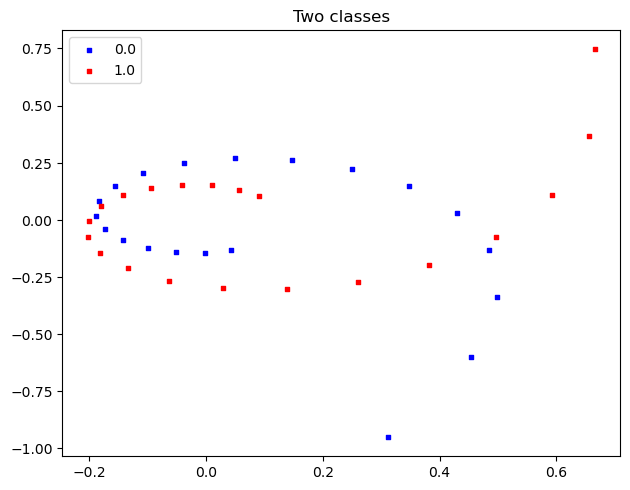

In [407]:
# 
fig = plt.figure()
ax1 = fig.add_subplot(111)
# df_cl1 = df[df.label == 0]
# df_cl2 = df[df.label == 1]
for i in range(dataset_size):
    if ys[i][0] == 0.:
        clr ='b'
    else:
        clr = 'r'
    ax1.scatter(xs[i][:, 0], xs[i][:, 1], s=5, c=clr, marker="s", label=ys[i][0])
#     ax1.scatter(df_cl2.x1, df_cl2.x2, s=5, c='r', marker="s", label='class2')
fig.tight_layout()
plt.title('Two classes')
plt.legend()


# plt.scatter(xs[0][:, 0], xs[0][:, 1])

In [408]:
# larger data set
dataset_size = 100
batch_size = 10
seq_length = 20
data_key, model_key = jax.random.split(jax.random.PRNGKey(212), 2)
xs, ys = get_data(dataset_size, seq_length, key=data_key)
iter_data = dataloader((xs, ys), batch_size)


In [409]:
xs.shape

(100, 20, 2)

In [410]:
ys[:2]

Array([[0.],
       [0.]], dtype=float32)

In [411]:
iter_data = dataloader(datasetHL, 100)

In [412]:
for (x, y) in iter_data:
    print(x.shape, y.shape)

(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)


(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)


(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)


(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)


(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)
(100, 100) (100, 2)


KeyboardInterrupt: 

In [210]:
class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jax.Array

    def __init__(self, in_size, out_size, hidden_size, *, key):
        ckey, lkey = jax.random.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
#         self.cell = eqx.nn.LSTMCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, inp):
            return self.cell(inp, carry), None

        out, _ = jax.lax.scan(f, hidden, input)
        # sigmoid because we're performing binary classification
        return jax.nn.sigmoid(self.linear(out) + self.bias)

In [321]:
class RNNlstm(eqx.Module):
    hidden_size: int
    cell1: eqx.Module
    cell2: eqx.Module
    linear: eqx.nn.Linear
#     bias: jax.Array

    def __init__(self, in_size, out_size, hidden_size, *, key):
        c1key, c2key, lkey = jax.random.split(key, 3)
        self.hidden_size = hidden_size
#         self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.cell1 = eqx.nn.LSTMCell(in_size, hidden_size, key=c1key)
        self.cell2 = eqx.nn.LSTMCell(hidden_size, hidden_size, key=c2key)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=True, key=lkey)
#         self.bias = jnp.zeros(out_size)

    def __call__(self, xs):
        scan_fn = lambda state, x: (self.cell1(x, state), None)
        init_state = (jnp.zeros(self.cell1.hidden_size),
                      jnp.zeros(self.cell1.hidden_size))
        final_state, _ = jax.lax.scan(scan_fn, init_state, xs)
        
        return self.linear(final_state[0]) # + self.bias
#         return jax.nn.sigmoid(self.linear(final_state[0]) + self.bias)

In [323]:
lstmeq = RNNlstm(2, 2, 32, key=model_key)

In [324]:
lstmeq(xs[0][:5, :])

Array([0.13397285, 0.09302421], dtype=float32)

In [253]:
lstmeq.cell

LSTMCell(
  weight_ih=f32[128,2],
  weight_hh=f32[128,32],
  bias=f32[128],
  input_size=2,
  hidden_size=32,
  use_bias=True
)

In [254]:
lstmeq = RNNlstm(100, 2, 32, key=model_key)

In [415]:
def main(
    dataset_size=100,
    batch_size=10,
    learning_rate=3e-3,
    steps=200,
    hidden_size=32,
    depth=1,
    seed=5678,
):
    data_key, model_key = jax.random.split(jax.random.PRNGKey(seed), 2)
    xs, ys = get_data(dataset_size, seq_length=14, key=data_key)
    iter_data = dataloader((xs, ys), batch_size)

    model = RNN(in_size=2, out_size=1, hidden_size=hidden_size, key=model_key)
#     model = RNNlstm(in_size=2, out_size=1, hidden_size=hidden_size, key=model_key)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x)
        # Trains with respect to binary cross-entropy
        return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    for step, (x, y) in zip(range(steps), iter_data):
        loss, model, opt_state = make_step(model, x, y, opt_state)
        loss = loss.item()
        print(f"step={step}, loss={loss}")

    pred_ys = jax.vmap(model)(xs)
    num_correct = jnp.sum((pred_ys > 0.5) == ys)
    final_accuracy = (num_correct / dataset_size).item()
    print(f"final_accuracy={final_accuracy}")

In [422]:
main()  # All right, let's run the code.

starting epoch 0
step=0, loss=0.7081233263015747
step=1, loss=0.6880833506584167
step=2, loss=0.6670365333557129
step=3, loss=0.6492072343826294
step=4, loss=0.628685712814331
step=5, loss=0.7848258018493652
step=6, loss=0.7960376739501953
step=7, loss=0.7989193797111511
step=8, loss=0.7965542674064636
step=9, loss=0.7902571558952332
starting epoch 1
step=10, loss=0.6111821532249451
step=11, loss=0.6148279309272766
step=12, loss=0.6153644919395447
step=13, loss=0.6149423718452454
step=14, loss=0.6114858984947205
step=15, loss=0.7869271636009216
step=16, loss=0.7895097732543945
step=17, loss=0.7881371378898621
step=18, loss=0.7853938937187195
step=19, loss=0.7801624536514282
starting epoch 2
step=20, loss=0.6177666187286377
step=21, loss=0.6210214495658875
step=22, loss=0.6220059394836426
step=23, loss=0.6227951645851135
step=24, loss=0.6206672787666321
step=25, loss=0.7737724184989929
step=26, loss=0.7754095196723938
step=27, loss=0.7729578018188477
step=28, loss=0.771012008190155
step

In [214]:
model = RNN(in_size=2, out_size=1, hidden_size=32, key=model_key)

In [215]:
model.cell.input_size

2

In [216]:
model.cell.weight_hh.shape

(96, 32)

In [218]:
model.cell.weight_ih.shape

(96, 2)

In [225]:
model(xs[0][:2, :])

Array([0.47193635], dtype=float32)

In [224]:
xs[0][:2, :]

Array([[-0.8662967 ,  0.49952984],
       [-0.6736304 ,  0.0267801 ]], dtype=float32)

In [220]:
xs[0]

Array([[-0.8662967 ,  0.49952984],
       [-0.6736304 ,  0.0267801 ],
       [-0.45926854, -0.21823113],
       [-0.24502712, -0.3264408 ],
       [-0.05450387, -0.33652925],
       [ 0.09283558, -0.2775747 ],
       [ 0.18502338, -0.17752427],
       [ 0.21916799, -0.06335385],
       [ 0.20130827,  0.04121126],
       [ 0.1447245 ,  0.11829499],
       [ 0.06710994,  0.1577503 ],
       [-0.01282473,  0.15779418],
       [-0.07866701,  0.12425242],
       [-0.11894477,  0.06858669]], dtype=float32)

In [ ]:
data_key, model_key = random.split(jax.random.PRNGKey(212), 2)
lstmj = LSTMjax(100, 500, 2)
params = lstmj.initialize_params(model_key)
for i in params.keys():
    print(i, params[i].shape)

# optimizer
# import optax
learning_rate = 0.001
batch_size = 100
#data_loader = DataLoaderXY(datasetHL[0], datasetHL[1], batch_size=batch_size)

# train_size = X_train.shape[0]
num_epochs = 500
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    def l2_loss(params, x, y):
        y_pred = lstmj.forward(x, params)
        l2 = jnp.mean((y_pred[-3:] - y[-3:])**2)
        return l2
    
    @jax.jit
    def run_batch(params, opt_state, batch_x, batch_y):
        loss_value, grads = jax.value_and_grad(l2_loss)(params, batch_x, batch_y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for i in range(num_epochs):
        data_loader = DataLoaderXY(datasetHL[0], datasetHL[1], batch_size=batch_size)
        j = 0
        for batch in data_loader:
            params, opt_state, loss_value = run_batch(params, opt_state, batch[0], batch[1])
#             if j % 2 == 0:
#                 print(f'batch {j}, loss: {loss_value}')
#             j += 1
        if i % 10 == 0: print(f'epoch {i}, loss: {loss_value}')
        i += 1
        
    return params

# Fit our parametrized function using the Adam optimizer

optimizer = optax.adam(learning_rate=learning_rate)
params = fit(params, optimizer)


In [359]:
# apply to spy ts
def main_spy(
    batch_size=100,
    learning_rate=3e-2,
    steps=1000,
    hidden_size=64,
#     depth=1,
    seed=5678,
):
    data_key, model_key = jax.random.split(jax.random.PRNGKey(seed), 2)
#     xs, ys = get_data(dataset_size, seq_length=14, key=data_key)
    iter_data = dataloader(datasetHL111, batch_size)
#     iter_data = DataLoaderXY(datasetHL[0], datasetHL[1], batch_size=batch_size)

#    model = RNN(in_size=2, out_size=1, hidden_size=hidden_size, key=model_key)
    model = RNNlstm(in_size=2, out_size=2, hidden_size=hidden_size, key=model_key)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x)
        l2 = jnp.mean((pred_y - y)**2)
        return l2
#         Trains with respect to binary cross-entropy
#         return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

    # Important for efficiency whenever you use JAX: wrap everything into a single JIT
    # region.
    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    for step, (x, y) in zip(range(steps), iter_data):
        loss, model, opt_state = make_step(model, x, y, opt_state)
        loss = loss.item()
        if step % 100 == 0: print(f"step={step}, loss={loss}")

    pred_ys = jax.vmap(model)(xs)
#     num_correct = jnp.sum((pred_ys > 0.5) == ys)
#     final_accuracy = (num_correct / dataset_size).item()
    final_loss = compute_loss(model, datasetHL111[0], datasetHL111[1])
    print(f"final_loss={final_loss}")
    return model

In [360]:
iter_data = dataloader(datasetHL111, 100)
for step, (x, y) in zip(range(2), iter_data):
    print(step)
    print(x.shape)
    print(y.shape)


0
(100, 50, 2)
(100, 2)
1
(100, 50, 2)
(100, 2)


In [435]:
model = main_spy(batch_size=100, steps=1000, hidden_size=64)

starting epoch 0
step=0, loss=1.1301002502441406
starting epoch 1
starting epoch 2
starting epoch 3
starting epoch 4
step=100, loss=0.00016478847828693688
starting epoch 5
starting epoch 6
starting epoch 7
starting epoch 8
step=200, loss=0.0001474556338507682
starting epoch 9
starting epoch 10
starting epoch 11
starting epoch 12
step=300, loss=0.00014378958439920098
starting epoch 13
starting epoch 14
starting epoch 15
starting epoch 16
step=400, loss=0.00013253962970338762
starting epoch 17
starting epoch 18
starting epoch 19
starting epoch 20
step=500, loss=0.0001378312153974548
starting epoch 21
starting epoch 22
starting epoch 23
starting epoch 24
step=600, loss=0.00015274550241883844
starting epoch 25
starting epoch 26
starting epoch 27
starting epoch 28
step=700, loss=0.00018181881750933826
starting epoch 29
starting epoch 30
starting epoch 31
starting epoch 32
step=800, loss=0.0002262513298774138
starting epoch 33
starting epoch 34
starting epoch 35
starting epoch 36
step=900, l

In [433]:
model(datasetHL111[0][-1])

Array([1.0139813 , 0.97831607], dtype=float32)

In [425]:
datasetHL111[0][-1]

Array([[0.99454296, 1.0431349 ],
       [1.0007769 , 0.9767036 ],
       [1.0010432 , 1.0071555 ],
       [0.98412615, 1.1107165 ],
       [0.9957643 , 1.0042644 ],
       [1.0199081 , 0.90392786],
       [1.0085351 , 0.92660004],
       [0.99899024, 1.0190114 ],
       [0.9887608 , 1.1057215 ],
       [0.993136  , 1.031496  ],
       [0.992917  , 1.0954199 ],
       [1.0185126 , 0.8556496 ],
       [1.0002666 , 0.98778355],
       [0.9956147 , 1.0429918 ],
       [1.0046724 , 0.9565218 ],
       [0.998256  , 0.9994097 ],
       [0.9986898 , 1.0059067 ],
       [1.00345   , 1.0052848 ],
       [0.99331737, 1.0508177 ],
       [1.012139  , 0.93774325],
       [1.0096332 , 0.9513929 ],
       [0.99854493, 1.0473521 ],
       [1.0004061 , 1.0237954 ],
       [0.98877716, 1.0766997 ],
       [0.9927551 , 1.0809498 ],
       [1.00866   , 0.9555666 ],
       [1.0129507 , 0.93782663],
       [1.000381  , 0.97270185],
       [0.9944548 , 1.0274915 ],
       [1.009501  , 0.87235224],
       [1.

In [426]:
datasetHL111[1][-1]

Array([1.0011505, 0.9893295], dtype=float32)

In [427]:
data[[('Ret', 'SPY'), ('Ret', '^VIX')]].tail(50)

Ret          
                 SPY      ^VIX
Date                          
2023-04-27  1.019908  0.903928
2023-04-28  1.008535  0.926600
2023-05-01  0.998990  1.019011
2023-05-02  0.988761  1.105721
2023-05-03  0.993136  1.031496
2023-05-04  0.992917  1.095420
2023-05-05  1.018513  0.855650
2023-05-08  1.000266  0.987784
2023-05-09  0.995615  1.042992
2023-05-10  1.004672  0.956522
2023-05-11  0.998256  0.999410
2023-05-12  0.998690  1.005907
2023-05-15  1.003450  1.005285
2023-05-16  0.993317  1.050818
2023-05-17  1.012139  0.937743
2023-05-18  1.009633  0.951393
2023-05-19  0.998545  1.047352
2023-05-22  1.000406  1.023795
2023-05-23  0.988777  1.076700
2023-05-24  0.992755  1.080950
2023-05-25  1.008660  0.955567
2023-05-26  1.012951  0.937827
2023-05-30  1.000381  0.972702
2023-05-31  0.994455  1.027491
2023-06-01  1.009501  0.872352
2023-06-02  1.014461  0.932907
2023-06-05  0.998084  1.008904
2023-06-06  1.002177  0.947726
2023-06-07  0.996542  0.998567
2023-06-08  1.006049  0.979197
2023-06-09  1.001794  1.013187
2023-06-12  1.009072  1.085322
2023-06-13  1.006593  0.973351
2023-06-14  1.001191  0.950034
2023-06-15  1.012398  1.044669
2023-06-16  0.996594  0.933793
2023-06-20  0.994812  1.025111
2023-06-21  0.994876  0.951009
2023-06-22  1.003610  0.978030
2023-06-23  0.992440  1.041053
2023-06-26  0.995914  1.060268
2023-06-27  1.010963  0.964211
2023-06-28  1.000504  0.977438
2023-06-29  1.003941  1.008191
2023-06-30  1.011801  1.003693
2023-07-03  1.001151  0.998528
2023-07-05  0.998513  1.044952
2023-07-06  0.992169  1.088857
2023-07-07  0.997475  0.960492
2023-07-10  1.002531  1.016183

In [434]:
model(jnp.array(data[[('Ret', 'SPY'), ('Ret', '^VIX')]].tail(50)))

Array([1.013761  , 0.97826207], dtype=float32)

#### LSTM implementation X

In [ ]:
import jax
import jax.numpy as np
from jax import random, grad, jit
import optax

class LSTM:
    def __init__(self, hidden_size, output_size):
        self.hidden_size = hidden_size
        self.output_size = output_size

    def initialize_params(self, rng):
        k1, k2, k3, k4 = random.split(rng, 4)
        input_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k1, (self.hidden_size, self.hidden_size))
        forget_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k2, (self.hidden_size, self.hidden_size))
        output_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k3, (self.hidden_size, self.hidden_size))
        cell_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k4, (self.hidden_size, self.hidden_size))
        output_weights_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k1, (self.hidden_size, self.output_size))
        return input_init, forget_init, output_init, cell_init, output_weights_init

    def lstm_cell(self, carry, inputs):
        hidden_state, cell_state = carry
        concat_input = np.concatenate([inputs, hidden_state], axis=-1)
        input_gate = np.sigmoid(np.dot(concat_input, self.input_weights))
        forget_gate = np.sigmoid(np.dot(concat_input, self.forget_weights))
        output_gate = np.sigmoid(np.dot(concat_input, self.output_weights))
        cell_candidate = np.tanh(np.dot(concat_input, self.cell_weights))
        new_cell_state = forget_gate * cell_state + input_gate * cell_candidate
        new_hidden_state = output_gate * np.tanh(new_cell_state)
        return new_hidden_state, (new_hidden_state, new_cell_state)

    def forward(self, inputs, params):
        self.input_weights, self.forget_weights, self.output_weights, self.cell_weights, self.output_weights = params
        _, final_state = jax.lax.scan(self.lstm_cell, (np.zeros((inputs.shape[0], self.hidden_size)),
                                                       np.zeros((inputs.shape[0], self.hidden_size))),
                                      inputs)
        return np.dot(final_state[0], self.output_weights)

    def loss(self, inputs, targets, params):
        predictions = self.forward(inputs, params)
        return np.mean((predictions - targets) ** 2)

    def update(self, inputs, targets, params, opt_state):
        loss_value, grads = jax.value_and_grad(self.loss)(inputs, targets, params)
        updates, new_opt_state = opt_update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return loss_value, new_params, new_opt_state

In [ ]:
def train_lstm_model(model, inputs, targets, num_epochs, learning_rate, batch_size):
    rng = jax.random.PRNGKey(0)
    params = model.initialize_params(rng)
#     opt_init, opt_update, get_params = optax.adam(learning_rate)
    optim = optax.adam(learning_rate)
    opt_state = optim.init(params)

    @jit
    def run_epoch(inputs, targets, params, opt_state):
        num_batches = inputs.shape[0] // batch_size
        losses = []
        for batch_idx in range(num_batches):
            batch_inputs = inputs[batch_idx * batch_size:(batch_idx + 1) * batch_size]
            batch_targets = targets[batch_idx * batch_size:(batch_idx + 1) * batch_size]
            loss_value, params, opt_state = model.update(batch_inputs, batch_targets, params, opt_state)
            losses.append(loss_value)
        return np.mean(losses), params, opt_state

    for epoch in range(num_epochs):
        loss_value, params, opt_state = run_epoch(inputs, targets, params, opt_state)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss_value}")

    return get_params(params)

In [ ]:
# Prepare your time series data (inputs and targets)

# Define hyperparameters
num_epochs = 100
learning_rate = 0.001
batch_size = 32
hidden_size = 64
output_size = 1

# Create an instance of the LSTM model
model = LSTM(hidden_size, output_size)

# Train the LSTM model
trained_params = train_lstm_model(model, inputs, targets, num_epochs, learning_rate, batch_size)

In [150]:
import jax
import jax.numpy as np
from jax import random, grad, jit
import optax

class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def initialize_params(self, rng):
        k1, k2, k3, k4 = random.split(rng, 4)
        input_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k1, (self.input_size, self.hidden_size))
        forget_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k2, (self.input_size, self.hidden_size))
        output_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k3, (self.input_size, self.hidden_size))
        cell_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k4, (self.input_size, self.hidden_size))
        output_weights_init = np.sqrt(1.0 / self.hidden_size) * random.normal(k1, (self.hidden_size, self.output_size))
        return input_init, forget_init, output_init, cell_init, output_weights_init

    def lstm_cell(self, carry, inputs):
        hidden_state, cell_state = carry
        #concat_input = np.concatenate([inputs, hidden_state], axis=-1)
        input_gate = jax.nn.sigmoid(inputs@self.input_weights)
        forget_gate = jax.nn.sigmoid(np.dot(inputs, self.forget_weights))
        output_gate = jax.nn.sigmoid(np.dot(inputs, self.output_weights))
        cell_candidate = jax.nn.tanh(np.dot(inputs, self.cell_weights))
        new_cell_state = forget_gate * cell_state + input_gate * cell_candidate
        new_hidden_state = output_gate * jax.nn.tanh(new_cell_state)
        return new_hidden_state, (new_hidden_state, new_cell_state)

    def forward(self, inputs, params):
        self.input_weights, self.forget_weights, self.output_weights, self.cell_weights, self.output_weights = params
        print(inputs.shape[0], self.hidden_size)
        _, final_state = jax.lax.scan(self.lstm_cell, (np.zeros((inputs.shape[0], self.hidden_size)),
                                                       np.zeros((inputs.shape[0], self.hidden_size))),
                                      inputs)
        return np.dot(final_state[0], self.output_weights)

    def loss(self, inputs, targets, params):
        predictions = self.forward(inputs, params)
        return np.mean((predictions - targets) ** 2)

    def update(self, inputs, targets, params, opt_state):
        loss_value, grads = jax.value_and_grad(self.loss)(inputs, targets, params)
        updates, new_opt_state = opt_update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return loss_value, new_params, new_opt_state

In [151]:
input_size = 50
hidden_size = 64
output_size = 2
model = LSTM(input_size, hidden_size, output_size)

In [152]:
rng = jax.random.PRNGKey(0)
params = model.initialize_params(rng)
list(map(lambda i: i.shape, params))

[(50, 64), (50, 64), (50, 64), (50, 64), (64, 2)]

In [153]:
jax.nn.sigmoid(np.array(df[0:50]).transpose()@params[0]).shape

(4, 64)

In [154]:
jax.nn.sigmoid(np.dot(np.array(df[0:50]).transpose(), params[0])).shape

(4, 64)

In [155]:
model.forward(np.array(df[0:50]).transpose(), params)

4 64


TypeError: Incompatible shapes for dot: got (50,) and (64, 2).

In [132]:
params[0]@np.array(df[0:50])

TypeError: dot_general requires contracting dimensions to have the same shape, got (64,) and (50,).

In [124]:
(np.array(df[0:50]).transpose()@params[0]).shape

(4, 64)

In [83]:
type(np.array(df[0:100]))

jaxlib.xla_extension.ArrayImpl

In [84]:
model.forward(np.array(df[0:100]))

(100, 64) (4,)


ValueError: too many values to unpack (expected 2)

In [ ]:
# Prepare your time series data (inputs and targets)

# Define hyperparameters
num_epochs = 100
learning_rate = 0.001
batch_size = 32
hidden_size = 64
output_size = 1

# Train the LSTM model
trained_params = train_lstm_model(inputs, targets, num_epochs, learning_rate, batch_size, hidden_size, output_size)


In [85]:
import jax.numpy as jnp
import optax

class LSTM(jax.nn.Module):

    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.W_i = jax.nn.Dense(hidden_size, activation="relu")
        self.W_f = jax.nn.Dense(hidden_size, activation="relu")
        self.W_o = jax.nn.Dense(hidden_size, activation="relu")
        self.W_c = jax.nn.Dense(hidden_size, activation="relu")

    def __call__(self, x, h, c):
        # x is the input sequence, h is the hidden state, and c is the cell state

        # Compute the forget gate
        f = self.W_f(x) * h

        # Compute the input gate
        i = self.W_i(x) * h

        # Compute the output gate
        o = self.W_o(x) * h

        # Compute the new cell state
        c_new = f * c + i * self.W_c(x)

        # Compute the new hidden state
        h_new = o * jnp.tanh(c_new)

        return h_new, c_new


AttributeError: module 'jax.nn' has no attribute 'Module'